In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import Accuracy, MeanAbsoluteError

# Load dataset
csv_path = "/content/drive/MyDrive/fsdbus/stMTMV_water_quality_dataset.csv"
df = pd.read_csv(csv_path)

# Target encoding
df['Water_Quality_Label'] = df['Water_Quality_Label'].map({'Safe': 0, 'Unsafe': 1})

# Define selected features
selected_features = [
    "Temperature", "NPK_Ratio", "pH", "Lead_Concentration", "Chlorine_Level",
    "Humidity", "Pipe_Age", "Pipe_Length", "Pipe_Diameter", "Barometric_Pressure",
    "Turbidity", "Conductivity", "Speed_Limit", "Industrial_Waste", "Water_Pressure", "Capacity"
]

# Define input (X) and targets (y)
X = df[selected_features].values
y_class = df["Water_Quality_Label"].values
y_reg = df["Toxication_Level"].values

# Normalize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test sets
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X_scaled, y_class, y_reg, test_size=0.2, random_state=42)

# Build model
input_layer = tf.keras.Input(shape=(X.shape[1],))
x = tf.keras.layers.Dense(64, activation='relu')(input_layer)
x = tf.keras.layers.Dense(32, activation='relu')(x)

output_class = tf.keras.layers.Dense(1, activation='sigmoid', name="classification")(x)
output_reg = tf.keras.layers.Dense(1, activation='linear', name="toxicity")(x)

model = tf.keras.Model(inputs=input_layer, outputs=[output_class, output_reg])
model.compile(
    optimizer='adam',
    loss={
        "classification": BinaryCrossentropy(),
        "toxicity": MeanSquaredError()
    },
    metrics={
        "classification": Accuracy(),
        "toxicity": MeanAbsoluteError()
    }
)


# Train model
history = model.fit(X_train,
                    {"classification": y_class_train, "toxicity": y_reg_train},
                    validation_data=(X_test, {"classification": y_class_test, "toxicity": y_reg_test}),
                    epochs=1,
                    batch_size=64)

# Save model and scaler
model.save("/content/drive/MyDrive/fsdbus/stMTMV_selected_features_model.h5")
import joblib
joblib.dump(scaler, "/content/drive/MyDrive/fsdbus/scaler.save")


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - classification_accuracy: 0.0000e+00 - classification_loss: 0.7562 - loss: 2798.4663 - toxicity_loss: 2797.7100 - toxicity_mean_absolute_error: 44.5919 - val_classification_accuracy: 0.0000e+00 - val_classification_loss: 0.7749 - val_loss: 1080.7804 - val_toxicity_loss: 1078.9001 - val_toxicity_mean_absolute_error: 27.4382


['/content/drive/MyDrive/fsdbus/scaler.save']

In [ ]:
pip install streamlit tensorflow scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install shap

In [7]:
import numpy as np
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load trained model and scaler
model = load_model("/content/drive/MyDrive/fsdbus/stMTMV_selected_features_model.h5")
scaler = joblib.load("/content/drive/MyDrive/fsdbus/scaler.save")

# Define feature names (order matters!)
feature_names = [
    "Temperature (°C)", "NPK Ratio", "pH Level", "Lead Concentration (mg/L)", "Chlorine Level (mg/L)",
    "Humidity (%)", "Pipe Age (years)", "Pipe Length (meters)", "Pipe Diameter (mm)",
    "Barometric Pressure (hPa)", "Turbidity (NTU)", "Conductivity (µS/cm)", "Speed Limit (km/h)",
    "Industrial Waste (%)", "Water Pressure (psi)", "Capacity (L/min)"
]

# Create input widgets
input_widgets = {
    name: widgets.FloatText(
        description=name,
        layout=widgets.Layout(width='400px'),
        style={'description_width': '250px'}
    ) for name in feature_names
}

# Create button and output display
submit_button = widgets.Button(description="Predict Water Quality", button_style='success')
output = widgets.Output()

# Define prediction logic
def on_predict_clicked(b):
    with output:
        clear_output()
        try:
            # Get inputs from user
            values = [input_widgets[name].value for name in feature_names]
            sample = np.array([values])
            sample_scaled = scaler.transform(sample)

            # Get model predictions
            class_output, toxicity_output = model(sample_scaled, training=False)
            class_prob = class_output[0][0].numpy()
            toxicity_level = round(toxicity_output[0][0].numpy(), 5)

            # Classification result
            is_safe = "Safe" if class_prob < 0.5 else "Unsafe"

            # Potability rules
            potable = True
            issues = []

            if not (6.5 <= input_widgets["pH Level"].value <= 8.5):
                potable = False
                issues.append("pH out of range")

            if input_widgets["Lead Concentration (mg/L)"].value > 0.015:
                potable = False
                issues.append("Lead too high")

            if input_widgets["Turbidity (NTU)"].value > 1:
                potable = False
                issues.append("Turbidity too high")

            if not (0.2 <= input_widgets["Chlorine Level (mg/L)"].value <= 4.0):
                potable = False
                issues.append("Chlorine level unsafe")

            if input_widgets["Conductivity (µS/cm)"].value > 2500:
                potable = False
                issues.append("High conductivity")

            if input_widgets["Industrial Waste (%)"].value > 0:
                potable = False
                issues.append("Industrial waste present")

            if toxicity_level > 10:
                potable = False
                issues.append("Toxication level high")

            # Display results
            print("🔍 Prediction Results")
            print(f"✅ Water Quality: {is_safe} (Prob: {round(class_prob, 4)})")
            print(f"☣️  Toxication Level: {toxicity_level}%")

            if potable:
                print("💧 Potability Status: ✅ *Water is POTABLE* (Safe for drinking)")
            else:
                print("💧 Potability Status: ❌ *Water is NOT POTABLE*")
                print("⚠️  Issues affecting potability:", ", ".join(issues))

            # Feature Attribution (using gradient)
            input_tensor = tf.convert_to_tensor(sample_scaled, dtype=tf.float32)
            with tf.GradientTape() as tape:
                tape.watch(input_tensor)
                class_output, _ = model(input_tensor)
                prediction = class_output[0][0]  # scalar output for class
            grads = tape.gradient(prediction, input_tensor).numpy()[0]
            importance = np.abs(grads)
            ranked_indices = np.argsort(-importance)

            print("\n📊 Ranked Feature Importance for Current Input:")
            for rank, idx in enumerate(ranked_indices):
                fname = feature_names[idx]
                val = round(values[idx], 3)
                imp_score = round(importance[idx], 5)
                print(f"{rank+1}. {fname} (Input: {val}) → Contribution: {imp_score}")

            top_feature = feature_names[ranked_indices[0]]
            top_score = round(importance[ranked_indices[0]], 5)
            print(f"\n🧠 Most Influential Factor: '{top_feature}' (Contribution Score: {top_score})")

        except Exception as e:
            print("❌ Error:", str(e))

# Link button to prediction function
submit_button.on_click(on_predict_clicked)

# Display form
display(widgets.VBox(list(input_widgets.values()) + [submit_button, output]))


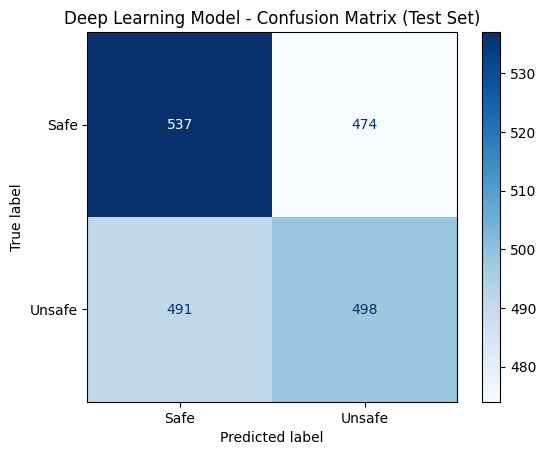

🔬 Deep Learning Model Evaluation
Accuracy: 0.5175
              precision    recall  f1-score   support

        Safe       0.52      0.53      0.53      1011
      Unsafe       0.51      0.50      0.51       989

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

# Load data
csv_path = "/content/drive/MyDrive/fsdbus/stMTMV_water_quality_dataset.csv"
df = pd.read_csv(csv_path)

# Prepare features and labels
model_features = [
    "Temperature", "NPK_Ratio", "pH", "Lead_Concentration", "Chlorine_Level",
    "Humidity", "Pipe_Age", "Pipe_Length", "Pipe_Diameter",
    "Barometric_Pressure", "Turbidity", "Conductivity", "Speed_Limit",
    "Industrial_Waste", "Water_Pressure", "Capacity"
]
X = df[model_features].values
y = LabelEncoder().fit_transform(df["Water_Quality_Label"])

# Split data into train and test sets (80-20 split, stratified to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== Deep Learning model prediction on test set ==========
# Load scaler and DL model
scaler = joblib.load("/content/drive/MyDrive/fsdbus/scaler.save")
dl_model = load_model("/content/drive/MyDrive/fsdbus/stMTMV_selected_features_model.h5")

# Scale test features
X_test_scaled = scaler.transform(X_test)

# Predict probabilities with DL model
dl_preds = dl_model.predict(X_test_scaled, verbose=0)

# Handle case where dl_preds is a list (e.g., model with multiple outputs)
if isinstance(dl_preds, list):
    dl_preds = dl_preds[0]

# Apply threshold to get class predictions
y_pred_dl = (dl_preds > 0.5).astype(int).flatten()

# Confusion matrix for DL
cm_dl = confusion_matrix(y_test, y_pred_dl)
disp_dl = ConfusionMatrixDisplay(confusion_matrix=cm_dl, display_labels=["Safe", "Unsafe"])
disp_dl.plot(cmap="Blues", values_format="d")
plt.title("Deep Learning Model - Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

print("🔬 Deep Learning Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_dl))
print(classification_report(y_test, y_pred_dl, target_names=["Safe", "Unsafe"]))


